# Выбор локации для скважины

Заказчиком является добывающая компания.

Требуется подготовить модель машинного обучения, которая должна предсказать в каком из регионов производить добычу нефти. Модель поможет оптимизировать добычу нефти, чтобы не начинать разработку в заведомо убыточных регионах. 

Бюджет на разработку скважин в регионе — 10 млрд рублей.
Один баррель сырья приносит 450 рублей дохода. 
Вероятность убытков должна быть меньше 2,5%.

**Данные**

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. 
 - geo_data_0.csv  (для региона "0")
 - geo_data_1.csv  (для региона "1")
 - geo_data_2.csv  (для региона "2")

Признаки:
 - id — уникальный идентификатор скважины;
 - f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
 - product — объём запасов в скважине (тыс. баррелей) - целевой параметр

## План работ

- Загрузить библиотеки и данные
- Провести исследовательский анализ
- Создание пайплайна и подбор гиперпараметров с помощью кросс-валидации (оценка объемов запасов)
- Рассчет прибыли и рисков
- Выбор наиболее подходящего региона

## Загрузка и подготовка данных

### Загрузка библиотек и датасетов

In [1]:
#установка недостающих библиотек  и недостающих обновлений в окружение
!pip install shap -q
!pip install phik -q
!pip install -U scikit-learn -q

In [2]:
#импорт библиотек и определение констант
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV
)

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import tree


from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler
)

from sklearn.linear_model import LinearRegression 

from sklearn.metrics import root_mean_squared_error

import warnings

RANDOM_STATE = 42

# константы для рассчета безубыточности
BUDGET = 10_000_000_000  # бюджет на разработку скважин в регионе
PRICE_THOUSAND_BARREL = 450_000 # доход с одной тысячи барелей

In [3]:
#игнорирование предупреждений
#warnings.filterwarnings('ignore')

In [4]:
#загрузка файла geo_data_0.csv
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
display(data_0.head())
data_0.info()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
#загрузка файла geo_data_1.csv
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
display(data_1.head())
data_1.info()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
#загрузка файла geo_data_2.csv
data_2 = pd.read_csv('/datasets/geo_data_2.csv')
display(data_2.head())
data_2.info()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


**Вывод**

Были получены три файла:

- geo_data_0.csv
     - число строк: 100000
     - число столбцов: 5
     - пустые значения: нет
     - типы данных: соответствуют данным в файлах
     - переименование столбцов: не требуется

- geo_data_1.csv
     - число строк: 100000
     - число столбцов: 5
     - пустые значения: нет
     - типы данных: соответствуют данным в файлах
     - переименование столбцов: не требуется

- geo_data_2.csv
     - число строк: 100000
     - число столбцов: 5
     - пустые значения: нет
     - типы данных: соответствуют данным в файлах
     - переименование столбцов: не требуется

### Предобработка данных

#### Поиск явных дубликатов

In [7]:
#поиск дубликатов
pd.concat([data_0, data_1, data_2]).duplicated().sum()

0

**Вывод**

Явные дубликаты не обнаружены

#### Поиск неявных дубликатов

In [8]:
# проверка наличия дублей id в файле data_0
len_0 = len(data_0) - len(data_0['id'].unique())
print('Число дублей номеров id:', (len_0 ))

Число дублей номеров id: 10


In [9]:
# проверка наличия дублей id в файле data_1
len_1 = len(data_1) - len(data_1['id'].unique())
print('Число дублей номеров id:', len_1 )

Число дублей номеров id: 4


In [10]:
# проверка наличия дублей id в файле data_2
len_2 = len(data_2) - len(data_2['id'].unique())
print('Число дублей номеров id:', len_2 )

Число дублей номеров id: 4


In [11]:
def del_id_dupl(df, len_):
    
    """
    функция для удаления строк с дубликатами id. 
    На вход принимает датафрейм и количество задублированных id
    """
    # отбор задублированных id
    index_dupl = (df['id']
                    .value_counts()  # подсчет количества строк для каждого id
                    .sort_values(ascending=False)  # сортиировка по убыванию
                    .head(len_)  # берем только верхнюю часть с дублями
                    .index)   # получение списка id дублей
    df = df.query('id not in @index_dupl')  # удаление дублей из датасета
    
    print('Число дублей номеров id:', (len(df) - len(df['id'].unique())) )    # прооверка количества дублей после удаления
    print('******************')
    print(df.info())
    return df
    

In [12]:
data_0 = del_id_dupl(data_0, len_0)

Число дублей номеров id: 0
******************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 99980 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99980 non-null  object 
 1   f0       99980 non-null  float64
 2   f1       99980 non-null  float64
 3   f2       99980 non-null  float64
 4   product  99980 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB
None


In [13]:
data_1 = del_id_dupl(data_1, len_1)

Число дублей номеров id: 0
******************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 99992 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99992 non-null  object 
 1   f0       99992 non-null  float64
 2   f1       99992 non-null  float64
 3   f2       99992 non-null  float64
 4   product  99992 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB
None


In [14]:
data_2 = del_id_dupl(data_2, len_2)

Число дублей номеров id: 0
******************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 99992 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99992 non-null  object 
 1   f0       99992 non-null  float64
 2   f1       99992 non-null  float64
 3   f2       99992 non-null  float64
 4   product  99992 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB
None


In [15]:
#поиск дубликатов значений параметров (после удаления id)
pd.concat([data_0, data_1, data_2]).drop(['id'], axis=1).duplicated().sum()

0

**Вывод**

Обнаружено, что во всех трех датасетах есть незначительное количетсов задублированных номеров id. Такие данные из датасетов были удалены.

### Исследовательский анализ данных

In [16]:
def hist_box_diagramm(df, list):
    """
    функция для строительства гистограммы и ящика с усами.
    на вход получает датафрейм и список полей для которых нужно построить графики
    """
    for element in list:   
        
        # создание объекта из двух: гстограммы и ящика с усами
        f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.15, .85)})
        
        # назначение графика каждой переменной
        sns.boxplot(df[element], orient='h', ax=ax_box)
        sns.histplot(df, x=element);
        
        print(f"Графики для поля: {element}")

        # удаление подписи для оси х
        ax_box.set(xlabel='')
        plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Графики для поля: f0


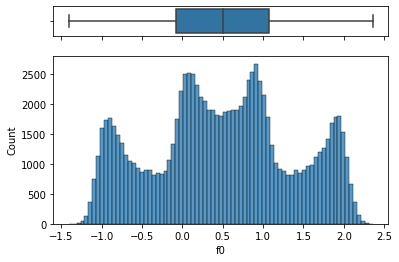

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Графики для поля: f1


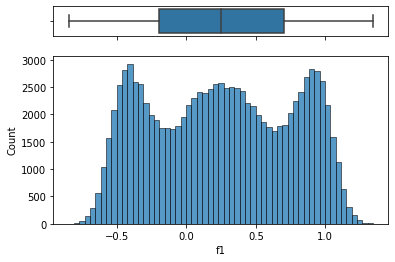

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Графики для поля: f2


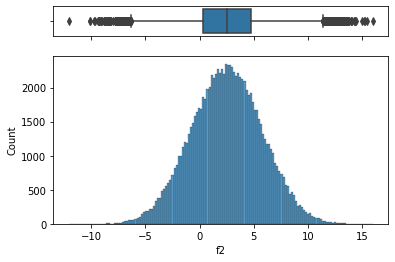

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Графики для поля: product


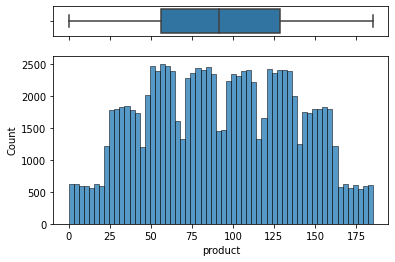

In [17]:
hist_box_diagramm(data_0, ['f0', 'f1', 'f2', 'product'])

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Графики для поля: f0


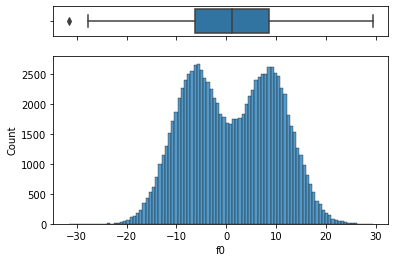

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Графики для поля: f1


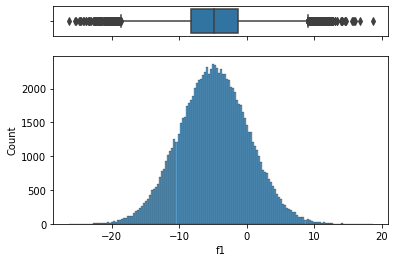

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Графики для поля: f2


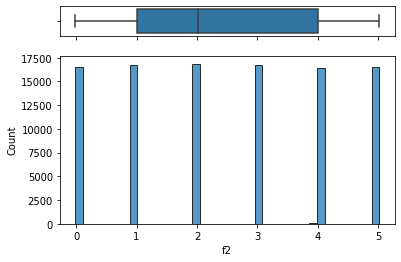

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Графики для поля: product


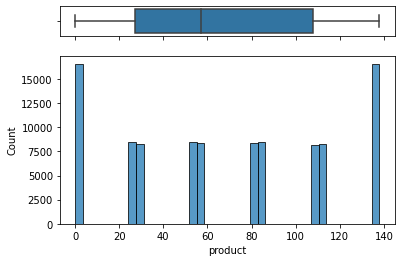

In [18]:
hist_box_diagramm(data_1, ['f0', 'f1', 'f2', 'product'])

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Графики для поля: f0


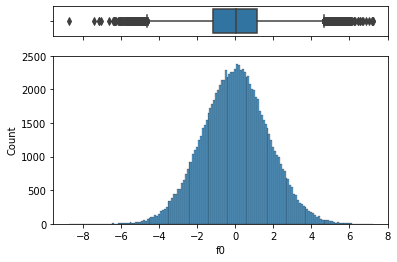

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Графики для поля: f1


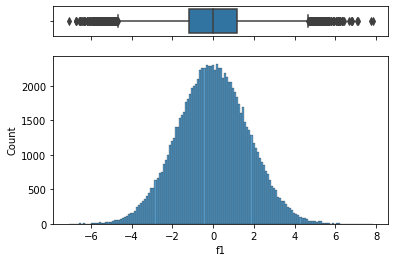

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Графики для поля: f2


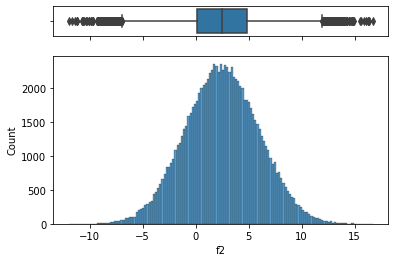

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Графики для поля: product


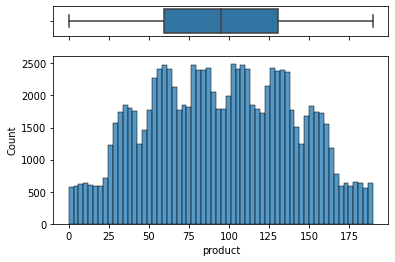

In [19]:
hist_box_diagramm(data_2, ['f0', 'f1', 'f2', 'product'])

In [20]:
def corr_num(df, list):
    """
    функция, которая строит матрицу корреляций Пирсона. На вход получает датафрейм и список числовых параметров
    для которых требуется найти корреляцию. На выходе выдает матрицу корреляции
    """
    plt.figure(figsize=(5, 4));
    sns.heatmap(df
                .loc[:, list]  #отбор нужных столбцов
                .corr(), annot=True, cmap='coolwarm', vmin=-1 # построение матрицы корреляции
               );
    plt.title('Корреляционная матрица между числовыми параметрами');

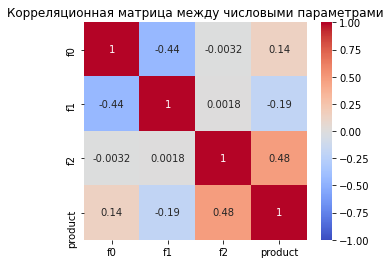

In [21]:
corr_num(data_0, ['f0', 'f1', 'f2', 'product'])

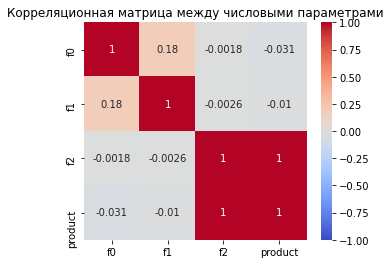

In [22]:
corr_num(data_1, ['f0', 'f1', 'f2', 'product'])

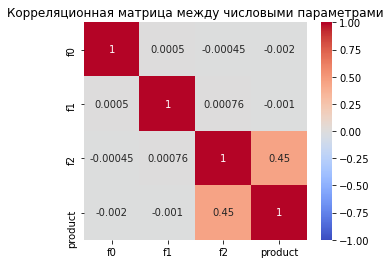

In [23]:
corr_num(data_2, ['f0', 'f1', 'f2', 'product'])

Корреляционный анализ показал, что коррелияция между f2 и product для датасета geo_data_1.csv равна 1. Стоит проверить не являются ли данные в одном столбце результатом умножения данных из другого столбца на коэффициент.

In [24]:
# проверка является ли папраметр f0 результатом прямого умножения целевого параметра на коэффициент

# отбор строк с ненулевым значением product
data = data_1.query('product != 0')
# рассчет коэффициентов
coef = data['f2'] / data['product']
# проверка количества различных коэффициентов
len(coef.unique())

91757

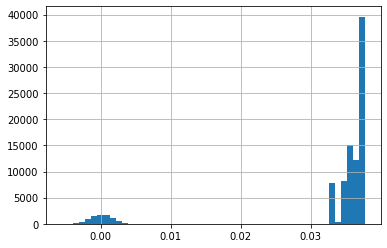

In [25]:
# график коэффициентов
coef.hist(bins=50);

**Вывод**

По результатам исследования данных понятно, что распределения данных в трех регионах разные. Поэтому необходимо обучать три разные модели (для каждого региона свою). Более того, судя по всему, данные для параметров f2 и product для датасета geo_data_1.csv собирались спобом отличным от двух других регионов, что видно на графиках для этих параметров.


Корреляционный анализ показал, что коррелияция между f2 и product для датасета geo_data_1.csv равна 1. Проведена проверка не являются ли данные в одном столбце результатом умножения данных из другого столбца на коэффициент. Нет, не являются. Удаление признаков не требуется.

## Обучение и проверка модели

### Создание переменных для пайплайна

In [26]:
#количественные признаки
num_columns = ['f0', 'f1', 'f2']

In [27]:
def train_test_split_func(df, RANDOM_STATE):
    """
    Функция для разбиения датафрейма на тренировочные и тестовые выборки.
    На вход получает датафрейм и RANDOM_STATE, на выход отдает 4 выборки (2 тренировочне, 2 тестовые) 
    с разбиением 75/25  тренировочные/тестовые
    """
    X = df.drop(['id', 'product'], axis=1)
    y = df['product']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
    return X_train, X_test, y_train, y_test

In [28]:
#деление на тренировочные и тестовые выборки
X0_train, X0_test, y0_train, y0_test = train_test_split_func(data_0, RANDOM_STATE)
X0_train.shape, X0_test.shape, y0_train.shape, y0_test.shape

((74985, 3), (24995, 3), (74985,), (24995,))

In [29]:
#деление на тренировочные и тестовые выборки и параллельное удаление признака f2 из датасета
X1_train, X1_test, y1_train, y1_test = train_test_split_func(data_1, RANDOM_STATE)
X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape

((74994, 3), (24998, 3), (74994,), (24998,))

In [30]:
#деление на тренировочные и тестовые выборки
X2_train, X2_test, y2_train, y2_test = train_test_split_func(data_2, RANDOM_STATE)
X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape

((74994, 3), (24998, 3), (74994,), (24998,))

**Вывод**

Соданы обучающие и тренировочные выборки для всех трех моделей. Также созданы переменные со списками числовых параметров.

### Создание пайплайна

In [31]:
def pipe_line_cv(num_list):
    """
    функция с пайплайном. принимает на вход список наименований числовых параметров.
    на выходе отдает модель кроссвалидации готовой для обучения
    """
    # пайплайн для препроцессинга
    data_preprocessor = ColumnTransformer(
        [
            ('num', MinMaxScaler(), num_list)
        ], 
        remainder='passthrough'
    ) 

    # итоговый пайплайн: подготовка данных и модель
    pipe_final = Pipeline(
        [
            ('preprocessor', data_preprocessor),
            ('models', LinearRegression())
        ]
    ) 

    #параметры для кросс-валидации
    param_distributions = [
        # словарь для модели LinearRegression()
        {
            'models': [LinearRegression()],
            'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
        }
    ]

    #кросс-валидация
    search_cv = GridSearchCV(
        pipe_final, 
        param_distributions, 
        cv=5, 
        scoring='neg_mean_squared_error', 
        n_jobs=-1,
        error_score='raise'
    )
    return search_cv

In [32]:
GridCV_0 = pipe_line_cv(num_columns)

In [33]:
GridCV_0.fit(X0_train, y0_train);

In [34]:
#вывод метрики для лучшей модели на теринировочной выборке
print ('Метрика лучшей модели на тренировочной выборке:', ((-1) * GridCV_0.best_score_) ** 0.5 )

# предсказание на тестовых данных и вывод метрики для предсказания
y0_test_pred = GridCV_0.predict(X0_test)
print(f'Метрика RMSE на тестовой выборке: {root_mean_squared_error(y0_test, y0_test_pred)}')

Метрика лучшей модели на тренировочной выборке: 37.67199756191733
Метрика RMSE на тестовой выборке: 37.76114714593895


In [35]:
GridCV_0.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])

In [36]:
GridCV_1 = pipe_line_cv(num_columns)

In [37]:
GridCV_1.fit(X1_train, y1_train);

In [38]:
#вывод метрики для лучшей модели на теринировочной выборке
print ('Метрика лучшей модели на тренировочной выборке:', ((-1) * GridCV_1.best_score_) ** 0.5 )

# предсказание на тестовых данных и вывод метрики для предсказания
y1_test_pred = GridCV_1.predict(X1_test)
print(f'Метрика RMSE на тестовой выборке: {root_mean_squared_error(y1_test, y1_test_pred)}')

Метрика лучшей модели на тренировочной выборке: 0.8896263088165363
Метрика RMSE на тестовой выборке: 0.892863589877732


In [39]:
GridCV_0.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])

In [40]:
GridCV_2 = pipe_line_cv(num_columns)

In [41]:
GridCV_2.fit(X2_train, y2_train);

In [42]:
#вывод метрики для лучшей модели на теринировочной выборке
print ('Метрика лучшей модели на тренировочной выборке:', ((-1) * GridCV_2.best_score_) ** 0.5 )

# предсказание на тестовых данных и вывод метрики для предсказания
y2_test_pred = GridCV_2.predict(X2_test)
print(f'Метрика RMSE на тестовой выборке: {root_mean_squared_error(y2_test, y2_test_pred)}')

Метрика лучшей модели на тренировочной выборке: 40.030251883468594
Метрика RMSE на тестовой выборке: 40.13115560413051


In [43]:
GridCV_0.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])

**Вывод**

Было обучено три модели. Для каждого региона своя модель.
Была использована модель LinearRegression(). В качестве гипперпараметров использовалась разнаые методы масштабирования. Для всех трех моделей лучшим масшатбированием было выбран StandardScaler().

Сравенение метрик.

Для региона 0:
- Метрика лучшей модели на тренировочной выборке: 37.67199756191733
- Метрика RMSE на тестовой выборке: 37.76114714593895

Для региона 1:
- Метрика лучшей модели на тренировочной выборке: 0.8896263088165363
- Метрика RMSE на тестовой выборке: 0.892863589877732

Для региона 2:
- Метрика лучшей модели на тренировочной выборке: 40.030251883468594
- Метрика RMSE на тестовой выборке: 40.13115560413051

Для региона 1 такой низкий уровень метрики обсусловлен тем, что в данных для этого региона очень высокая корреляция между признаком f2 и объемом продукта, что привело к такой низкой метрике.

### Анализ значимости признаков

In [44]:
def feture_importance(model):
    # собираем датафрейм с наименованиями фичей и коэффициентами значимости
    feature_importances = pd.DataFrame(
        {
            'feature': model.best_estimator_['preprocessor'].get_feature_names_out(),
            'importance': model.best_estimator_['models'].coef_
        }).sort_values('importance', ascending=False)  #сортировка по убыванию значимости

    # построение гистограммы с важностью признаков
    plt.figure(figsize=(8, 4))

    ax = sns.barplot(x='importance', y='feature', data=feature_importances)

    ax.set_title('Важность признаков', fontsize=16)
    ax.set_xlabel('Важность (доля)', fontsize=14)
    ax.set_ylabel('Признак', fontsize=14)

    # отображаем график
    plt.show()

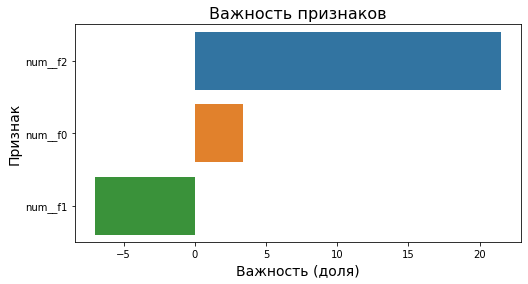

In [45]:
# важность признаков для GridCV_0
feture_importance(GridCV_0)

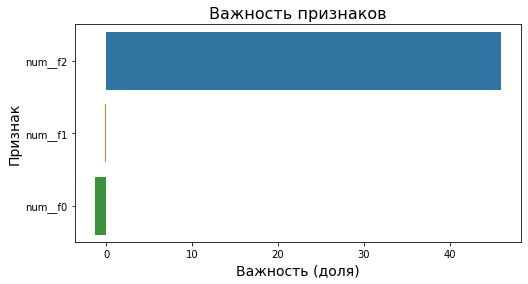

In [46]:
# важность признаков для GridCV_1
feture_importance(GridCV_1)

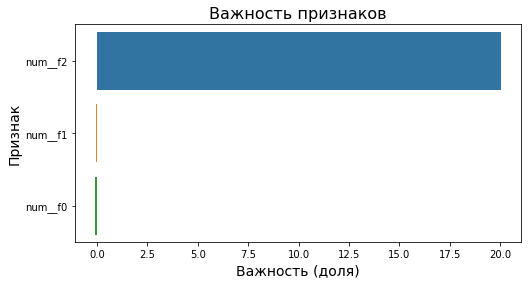

In [47]:
# важность признаков для GridCV_2
feture_importance(GridCV_2)

**Вывод**

Наиболее значимый параметр для предсказания объема продукта - f2.
Он оказывает наибольшее влияние на предсказание целевой переменной. Что также подвтерждается корреляционным анализом.

## Подготовка к расчёту прибыли

In [48]:
def merge_test(df, X_test, y_test_pred):
    """
    Функция для объединения тестовой выборки с предсказанным целевым признаком. 
    И добавлением id из исходного датасета.
    На вход принимает исходный датасет, тестовую выборку, предсказанный целевой признак.
    Возвращает датаферейм: тестовый датасет с предсказанным целевым признаком и id
    """
    X_test['product_pred'] = y_test_pred
    data_pred = X_test.join(df.loc[:, ['id', 'product']], how='left')
    display(data_pred.head())
    return data_pred

In [49]:
# создание датасета по региону 0 с предсказанными данными
data_0_pred = merge_test(data_0, X0_test, y0_test_pred)

,f0,f1,f2,product_pred,id,product
68295,0.096378,-0.200314,9.052483,140.415284,TvPMt,111.261742
40561,-0.268458,0.921819,3.194225,84.683193,T5p0r,3.240789
54254,1.604150,-0.317233,7.668558,138.812581,0Wa6d,156.430554
70638,1.577117,-0.495010,4.082067,117.496790,gfrG6,137.684050
44361,0.313237,-0.206565,-0.910742,75.558549,wCChH,126.213790


In [50]:
# создание датасета по региону 1 с предсказанными данными
data_1_pred = merge_test(data_1, X1_test, y1_test_pred)

,f0,f1,f2,product_pred,id,product
33968,0.518707,-5.983575,0.001335,1.745802,XObi5,0.000000
22856,-9.630271,-11.453777,2.996499,84.064523,0LdCb,84.038886
19451,7.486573,-11.046265,4.006074,108.784312,90oSG,107.813044
9735,10.448037,0.297406,1.011815,27.400959,HijQj,26.953261
7132,12.857577,-7.534200,0.010287,0.233071,yHiJJ,0.000000


In [51]:
# создание датасета по региону 2 с предсказанными данными
data_2_pred = merge_test(data_2, X2_test, y2_test_pred)

,f0,f1,f2,product_pred,id,product
33967,2.320681,-1.526151,3.003304,97.751163,DhRli,58.166745
22854,-0.714721,1.985878,2.593923,95.522584,TYMUG,179.573608
19449,-2.924051,2.719300,5.318565,111.332198,OnmV5,160.193413
9732,0.500312,-1.925757,-3.053501,62.984886,qju6o,34.079047
7129,-2.202068,2.999640,10.552605,141.426676,FbzYP,138.077543


In [52]:
# рассчет безубыточности. тыс баррелей, который надо добыть из одной скважины, чтобы выйти в 0 (точка безубыточности)
break_even = BUDGET / PRICE_THOUSAND_BARREL / 200
print(f"Точка безубыточности: {round(break_even, 2)} тыс. баррелей")

Точка безубыточности: 111.11 тыс. баррелей


In [53]:
print('Средний объем в месторождении 0:', round(data_0_pred['product'].mean(),2), 'тыс. баррелей')

Средний объем в месторождении 0: 92.37 тыс. баррелей


In [54]:
print('Средний объем в месторождении 1:', round(data_1_pred['product'].mean(),2), 'тыс. баррелей')

Средний объем в месторождении 1: 69.16 тыс. баррелей


In [55]:
print('Средний объем в месторождении 2:', round(data_2_pred['product'].mean(),2), 'тыс. баррелей')

Средний объем в месторождении 2: 95.06 тыс. баррелей


**Вывод**

Было проведены предварительный работы для подготовки рассчета доходности скважин.

Были созданы датасеты с объединенными данными (предсказанными и истинными).

Рассчитана точка безубыточности для добычи нефти из одной скважины: 111.11 тыс баррелей

Также рассчитаны средние объемы месторождений в регионах (тыс баррелей):
 - 92.37
 - 69.16
 - 95.06

Откуда видно, что регион "1" сильно отстает от двух других по среднему объему скважины. Также видно, что средний объем меньше точки безубыточности.

## Расчёт прибыли и рисков 

In [56]:
def top100_product(df, price_thousand_barrel = PRICE_THOUSAND_BARREL):
    """
    функция для суммирования количества нефти для 100 лучших месторождений в регионе и подсчета прибыли для них.
    на вход получает датафрейм с предсказанными значениями по каждому месторождению региона и стоимость прибыли для
    одной тысячи баррелей
    на выход отдает информацию о сумме 100 наибольших меторождений
    """
    top100 = df.sort_values(by='product', ascending=False).head(100)['product'].sum()
    print(f"Суммарное количество нефти в 100 месторождениях с наибльшим предсказанием объема нефти: \
{round(top100, 2)} тыс. баррелей")
    print(f"Прибыль для этого количетсва сырья составит: {round(top100 * price_thousand_barrel / 1e6, 2)} млн рублей")
    

In [57]:
# подсчет нефти для 10 лучших месторождений
top100_product(data_0_pred)

Суммарное количество нефти в 100 месторождениях с наибльшим предсказанием объема нефти: 18437.42 тыс. баррелей
Прибыль для этого количетсва сырья составит: 8296.84 млн рублей


In [58]:
# подсчет нефти для 10 лучших месторождений
top100_product(data_1_pred)

Суммарное количество нефти в 100 месторождениях с наибльшим предсказанием объема нефти: 13794.54 тыс. баррелей
Прибыль для этого количетсва сырья составит: 6207.54 млн рублей


In [59]:
# подсчет нефти для 10 лучших месторождений
top100_product(data_2_pred)

Суммарное количество нефти в 100 месторождениях с наибльшим предсказанием объема нефти: 18893.78 тыс. баррелей
Прибыль для этого количетсва сырья составит: 8502.2 млн рублей


In [60]:
def revenue(df, price_thousand_barrel = PRICE_THOUSAND_BARREL, budget = BUDGET):
    """
    функция для подсчета среднего значения прибыли двухсот лучших месторождений (за вычетом бюджетных средств)
    на вход получает датасет. на выходе: среднее значение
    """
    
    # отбор 200 лучших скважин и рассчет прибыли по каждой скважине
    df_sort = df.sort_values(by='product_pred', ascending=False).head(200)
    df_sort['revenue'] = df_sort['product'] * price_thousand_barrel
    
    #рассчет прибыли
    revenue = df_sort['revenue'].sum() - budget
    
    return revenue

In [61]:
def part_neg(series):
    """
    функция для подсчета процента отрицательных значений в серии
    на вход получает серию, на выходе отдает число
    """
           
    # подсчет и возврат процента отрицательных значений в выборке
    return (series < 0).mean() * 100

In [62]:
def confidence_interval(data, revenue = revenue, part_neg = part_neg):
    """
    функция для рассчета как для предсказанных так и для истинных значений product: 
    1. 95% доверительного интервала для средней прибыли скважины
    2. Процент шахт с отрицательной прибылью
    на вход получает датасет, на выходе получаем 4 доверительных интервала (для прибыли, для отрицательной прибыли, 
    выполненные на истинных значениях и на предсказанных)
    """
    state = np.random.RandomState(12345)
    
    reven_value = []
    
    
    # делаем 1000 выборок. Для каждой рассчитываем среднюю прибыль
    # на предсказанных и на истинных данных
    for i in range(1000):
        data_subsample = data.sample(500, replace=True, random_state=state)
        reven_value.append(revenue(data_subsample)) 
    
    #рассчет квантилей для прибыли 
    reven_value = pd.Series(reven_value)
    lower = reven_value.quantile(0.025) / 1e6 # приведение к млн руб
    upper = reven_value.quantile(0.975) / 1e6
    
    # рассчет средней прибыли
    reven_value_mean = reven_value.mean() / 1e6 # приведение к млн руб

    
            
    # подсчет процента отрицательных значений в выборке
    neg = part_neg(reven_value)
    
    print(f"95% доверительный интервал для прибыли: ({lower:.2f}, {upper:.2f}), млн руб.")
    print(f"Среднее значение прибыли: {reven_value_mean:.2f}, руб.")
    print(f"Процент шахт с отрицательной прибылью: {neg:.2f}%")    

In [63]:
# подсчет доверительных интервалов для data_0_pred
confidence_interval(data_0_pred)

95% доверительный интервал для прибыли: (-101.79, 931.56), млн руб.
Среднее значение прибыли: 396.71, руб.
Процент шахт с отрицательной прибылью: 7.20%


In [64]:
# подсчет доверительных интервалов для data_1_pred
confidence_interval(data_1_pred)

95% доверительный интервал для прибыли: (90.89, 894.38), млн руб.
Среднее значение прибыли: 488.47, руб.
Процент шахт с отрицательной прибылью: 1.00%


In [65]:
# подсчет доверительных интервалов для data_2_pred
confidence_interval(data_2_pred)

95% доверительный интервал для прибыли: (-120.49, 897.14), млн руб.
Среднее значение прибыли: 357.47, руб.
Процент шахт с отрицательной прибылью: 7.30%


**Вывод**

Был производен подсчет прибыли для 100 лучших месторождений (с наибольшим запасом нефти). Для всех трех регионов 100 месторождений недостаточно, чтобы восполнить бюджетные затраты.

Была рассчитана средняя прибыль, доверительный интервал для прибыли и вероятность отрицательной прибыли:

Регион 0
 - 95% доверительный интервал для прибыли: (-101.79, 931.56), млн руб.
 - Среднее значение прибыли: 396.71, руб.
 - Процент шахт с отрицательной прибылью: 7.20%

Регион 1
 - 95% доверительный интервал для прибыли: (90.89, 894.38), млн руб.
 - Среднее значение прибыли: 488.47, руб.
 - Процент шахт с отрицательной прибылью: 1.00%

Регион 2
 - 95% доверительный интервал для прибыли: (-120.49, 897.14), млн руб.
 - Среднее значение прибыли: 357.47, руб.
 - Процент шахт с отрицательной прибылью: 7.30%
 
у регионов 0 и 2 высокая вероятность получить отрицательную прибыль. Тогда как результаты по региону 1 обнадеживают. Следует выбрать регион 1 для разработки.

## Выводы

Было получено три датасета (каждый для отдельно взятого региона).
Данные, кроме идентификатора месторождения, содержали три параметра (f0, f1, f2), характерезующие месторождение и колчество нефти в месторождении (целевая переменная).

Во всех трех датасетах было обнаружено незначительное количество задвоившихся id, которые были удалены из датасетов. 

Т.к. распределения параметров разное в разных регионах, для каждого региона была обучена отдельная модель.
Модель: LinearRegression(). Масштабирование признаков: StandartScaler().
Для оценки качетсва модели исопльзовалась метрика RMSE.
Для региона 0:
- Метрика лучшей модели на тренировочной выборке: 37.67
- Метрика RMSE на тестовой выборке: 37.76

Для региона 1:
- Метрика лучшей модели на тренировочной выборке: 0.89
- Метрика RMSE на тестовой выборке: 0.89

Для региона 2:
- Метрика лучшей модели на тренировочной выборке: 40.03
- Метрика RMSE на тестовой выборке: 40.13

Для региона 1 такой низкий уровень метрики обсусловлен тем, что в данных для этого региона очень высокая корреляция между признаком f2 и объемом продукта, что привело к такой низкой метрике.

Кроме того, анализ значимости признаков также показал, что признак f2 оказывает наибольшие влияние на объем нефти в месторождении для всех регионов.

Анализ 95% доверительных интервалов для всех регионов показал, что лучшим для разработки является регион 1 со следующими значениями параметров:
 - 95% доверительный интервал для прибыли: (90.89, 894.38), млн руб.
 - Среднее значение прибыли: 488.47, руб.
 - Процент шахт с отрицательной прибылью: 1.00%